In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
from torchvision import transforms
from PIL import Image
import cv2
from tqdm import tqdm

In [3]:
def disparity_algorithm(Pl, Pr, dim1, dim2):
    '''
    Pl, Pr : Grayscale image with shape (1,1,H,W)
    '''
    D = torch.zeros(Pl.shape[-2], Pl.shape[-1])
    H, W = Pl.shape[-2:]
    N1 = int((dim1 - 1) / 2)
    N2 = int((dim2 - 1) / 2)
    # Pad to(1,1, H+dim1, W+dim2)
    Pl_pad = F.pad(Pl, (N1, N2, N1, N2))
    Pr_pad = F.pad(Pr, (N1, N2, N1, N2))
    
    # For each pixel
    for i in tqdm(range(H)):
        for j in range(W):
            # S map
            S = torch.zeros_like(D)
            
            left = i
            right = i + N1 + N1 + 1
            top = j
            bottom = j + N2 + N2 + 1
            #patch sizes = (1,1,dim1,dim2)

            patches = Pl_pad[:, :, left : right, top : bottom]
            # Second constant terms
            S += (patches ** 2).sum()
            #print(S)
            S -= 2 * F.conv2d(Pr_pad[:, :, left:right, :], patches, stride=1).squeeze(0).squeeze(0)
            
            S += F.conv2d(Pr_pad[:, :, left:right, :] * Pr_pad[:, :, left:right, :], torch.ones_like(patches), stride=1).squeeze(0).squeeze(0)
            
            #print(S[i,j])
            
            d = Pr_pad[:,:, left : right, top : bottom] - patches
            d = (d ** 2).sum()
            #print(d)
            #print(S[j])
            dmin = torch.argmin(S)
            

            D[i,j] = j - dmin
            
        #if i == 50 : break
          
        
    return D

In [13]:
corridorl = Image.open("img/corridorl.jpg")
corridorr = Image.open("img/corridorr.jpg")
corridordis = Image.open("img/corridor_disp.jpg")
transform = transforms.Compose([
    transforms.Grayscale(),
    transforms.ToTensor()
])

corridorl = transform(corridorl)
corridorl = corridorl.unsqueeze(0)
corridorr = transform(corridorr)
corridorr = corridorr.unsqueeze(0)
corridordis = transform(corridordis)
corridordis = corridordis.unsqueeze(0)

In [14]:
D = disparity_algorithm(corridorl, corridorr, 11, 11)

100%|█████████████████████████████████████████████████████████████████████████████████| 256/256 [00:13<00:00, 18.89it/s]


(-0.5, 255.5, 255.5, -0.5)

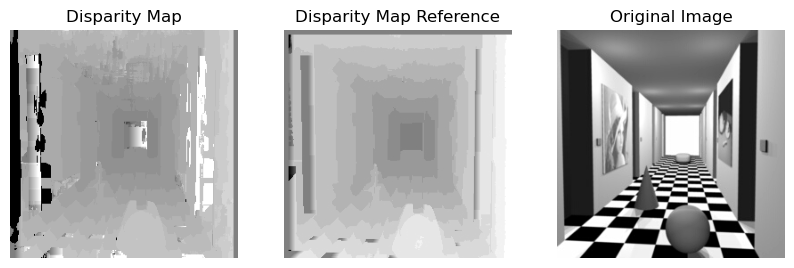

In [15]:
D_map = D.clone()
#D_map = -D_map
D_map[D_map > 15] = 15
D_map[D_map < -15] = -15
D_map = 255 * (D_map - D_map.min()) / (D_map.max() - D_map.min())
f, ax = plt.subplots(1,3, figsize = (10,8))
ax[0].imshow(D_map, cmap = 'gray')
ax[0].set_title("Disparity Map")
ax[0].axis("off")
ax[1].imshow(corridordis[0,0,:,:], cmap='gray')
ax[1].set_title("Disparity Map Reference")
ax[1].axis("off")
ax[2].imshow(corridorl[0,0,:,:], cmap='gray')
ax[2].set_title("Original Image")
ax[2].axis("off")

In [16]:
triclopsi2l = Image.open("img/triclopsi2l.jpg")
triclopsi2r = Image.open("img/triclopsi2r.jpg")
triclopsid = Image.open("img/triclopsid.jpg")

triclopsi2l = transform(triclopsi2l)
triclopsi2l = triclopsi2l.unsqueeze(0)
triclopsi2r = transform(triclopsi2r)
triclopsi2r = triclopsi2r.unsqueeze(0)
triclopsid = transform(triclopsid)
triclopsid = triclopsid.unsqueeze(0)

In [17]:
D = disparity_algorithm(triclopsi2l, triclopsi2r, 11, 11)

100%|█████████████████████████████████████████████████████████████████████████████████| 240/240 [00:18<00:00, 13.17it/s]


(-0.5, 319.5, 239.5, -0.5)

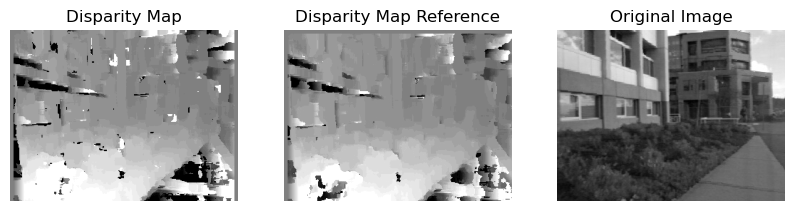

In [18]:
D_map = D.clone()
#D_map = -D_map
D_map[D_map > 15] = 15
D_map[D_map < -15] = -15
D_map = 255 * (D_map - D_map.min()) / (D_map.max() - D_map.min())
f, ax = plt.subplots(1,3, figsize = (10,8))
ax[0].imshow(D_map, cmap = 'gray')
ax[0].set_title("Disparity Map")
ax[0].axis("off")
ax[1].imshow(triclopsid[0,0,:,:], cmap='gray')
ax[1].set_title("Disparity Map Reference")
ax[1].axis("off")
ax[2].imshow(triclopsi2l[0,0,:,:], cmap='gray')
ax[2].set_title("Original Image")
ax[2].axis("off")